In [1]:
# @title ۱: نصب کتابخانه‌های مورد نیاز
# این سلول کتابخانه‌های لازم برای اجرای تحلیل را نصب می‌کند.
# BERTopic برای مدل‌سازی موضوعی و Transformers/Sentence-Transformers برای مدل‌های زبان.
!pip install bertopic==0.16.0
!pip install transformers sentence-transformers
!pip install pandas numpy scikit-learn
!pip install accelerate # برای بارگذاری بهینه مدل‌ها روی GPU

# برای مصورسازی نتایج نهایی
!pip install matplotlib seaborn

print("✅ نصب تمام کتابخانه‌های مورد نیاز با موفقیت انجام شد.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [2]:
# @title ۲: وارد کردن کتابخانه‌ها و تنظیمات اولیه
import pandas as pd
import numpy as np
import re
import torch
from tqdm.notebook import tqdm

# برای مدل‌سازی موضوعی
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

# برای تحلیل احساسات
from transformers import pipeline

# برای مصورسازی
import matplotlib.pyplot as plt
import seaborn as sns

print("✅ وارد کردن کتابخانه‌ها با موفقیت انجام شد.")

✅ وارد کردن کتابخانه‌ها با موفقیت انجام شد.


In [3]:
# @title ۳: بارگذاری و پیش‌پردازش داده‌های Reddit
# در این مرحله، دیتاست Reddit را بارگذاری کرده و متن‌ها را برای تحلیل آماده می‌کنیم.

# --- مسیر فایل دیتاست خود را اینجا قرار دهید ---
# فایل CSV که با اسکریپت قبلی استخراج کردید را در اینجا آپلود و مسیرش را وارد کنید.
file_path = 'reddit_retails_posts_2015_2025.csv'

try:
    df = pd.read_csv(file_path)
    print(f"✅ دیتاست با موفقیت از مسیر '{file_path}' بارگذاری شد.")
    print(f"شکل اولیه دیتاست: {df.shape}")
except FileNotFoundError:
    print(f"❌ خطا: فایل در مسیر '{file_path}' یافت نشد. لطفاً مسیر را بررسی کرده و فایل را آپلود کنید.")
    df = None # برای جلوگیری از خطاهای بعدی

# تابع پیش‌پردازش متن
# برای مدل‌های ترنسفورمر، پیش‌پردازش باید حداقلی باشد تا اطلاعات زمینه‌ای از بین نرود.
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    # حذف URL ها
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # حذف user mentions و هشتگ‌ها (در Reddit کمتر رایج است اما برای اطمینان)
    text = re.sub(r'\@\w+|\#','', text)
    # حذف کاراکترهای اضافه و خطوط جدید
    text = re.sub(r'\s+', ' ', text).strip()
    # تبدیل به حروف کوچک
    text = text.lower()
    return text

if df is not None:
    # --- ترکیب عنوان و متن پست ---
    # بسیاری از اطلاعات کلیدی در عنوان پست‌های Reddit قرار دارد.
    # ابتدا مقادیر خالی (NaN) در ستون body را با یک رشته خالی جایگزین می‌کنیم.
    df['body'] = df['body'].fillna('')
    # سپس عنوان و متن را با یک فاصله ترکیب می‌کنیم.
    df['full_text'] = df['title'] + ' ' + df['body']

    # اعمال تابع پیش‌پردازش روی متن کامل
    df['clean_text'] = df['full_text'].apply(preprocess_text)

    # --- پاکسازی نهایی دیتافریم ---
    # حذف سطرهای خالی یا بسیار کوتاه پس از پیش‌پردازش
    df.dropna(subset=['clean_text'], inplace=True)
    df = df[df['clean_text'].str.len() > 20] # حذف متن‌های خیلی کوتاه

    # حذف پست‌های تکراری
    df.drop_duplicates(subset=['clean_text'], inplace=True)

    print(f"✅ پیش‌پردازش با موفقیت انجام شد.")
    print(f"تعداد پست‌ها پس از پاکسازی: {len(df)}")

    # ایجاد لیست نهایی از متون برای ورودی به مدل‌ها
    docs = df['clean_text'].tolist()
    display(df[['company', 'clean_text']].head())
else:
    docs = None

✅ دیتاست با موفقیت از مسیر 'reddit_retails_posts_2015_2025.csv' بارگذاری شد.
شکل اولیه دیتاست: (8146, 9)
✅ پیش‌پردازش با موفقیت انجام شد.
تعداد پست‌ها پس از پاکسازی: 7694


,company,clean_text
0,Walmart,then go to walmart then 🙄 this customer came i...
1,Walmart,walmart beating target and other big box retai...
2,Walmart,looks like walmart is selling their tech… 🤔 ha...
3,Walmart,walmart price tag low iq me shopping at walmar...
4,Walmart,how do retail stores like walmart and dollar g...


In [4]:
# @title ۴: مدل‌سازی موضوعی با BERTopic
# در این مرحله، با استفاده از BERTopic موضوعات اصلی مطرح شده توسط مشتریان را کشف می‌کنیم.

if 'docs' in locals() and docs:
    print("⏳ شروع فرآیند مدل‌سازی موضوعی با BERTopic... (این مرحله ممکن است زمان‌بر باشد)")

    # برای جلوگیری از حذف کلمات کلیدی مهم در خرده‌فروشی (مانند 'no', 'not', 'sale')
    # یک لیست خالی از stop words به مدل می‌دهیم.
    vectorizer_model = CountVectorizer(stop_words=None)

    # بارگذاری مدل برای تبدیل متن به بردار (embedding)
    embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

    # ایجاد و آموزش مدل BERTopic
    # min_topic_size: حداقل تعداد پست برای تشکیل یک موضوع مستقل
    topic_model = BERTopic(
        embedding_model=embedding_model,
        vectorizer_model=vectorizer_model,
        language="english",
        min_topic_size=50, # این عدد را می‌توانید بر اساس حجم دیتاست خود تنظیم کنید
        calculate_probabilities=True,
        verbose=True
    )

    topics, probs = topic_model.fit_transform(docs)

    print("\n✅ آموزش مدل BERTopic با موفقیت به پایان رسید.")
    # موضوع -1 معمولاً outlier ها هستند (پست‌هایی که در هیچ دسته‌ای قرار نگرفته‌اند).
    print(f"تعداد {len(topic_model.get_topic_info())-1} موضوع معنادار کشف شد.")

    # نمایش اطلاعات کلی موضوعات کشف‌شده
    print("\n--- اطلاعات کلی موضوعات کشف شده: ---")
    topic_info = topic_model.get_topic_info()
    display(topic_info.head(10))

    # نمایش کلمات کلیدی برای ۱۰ موضوع برتر
    print("\n--- کلمات کلیدی برای ۱۰ موضوع برتر: ---")
    for i in range(min(10, len(topic_info)-1)):
        print(f"موضوع {i}: {topic_model.get_topic(i)}")

    # افزودن شناسه موضوع به دیتافریم اصلی برای تحلیل‌های بعدی
    df['topic_id'] = topics
else:
    print("❌ لیستی از متون برای تحلیل یافت نشد. لطفاً مرحله قبل را بررسی کنید.")

⏳ شروع فرآیند مدل‌سازی موضوعی با BERTopic... (این مرحله ممکن است زمان‌بر باشد)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2025-07-25 03:53:03,511 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/241 [00:00<?, ?it/s]

2025-07-25 03:58:04,654 - BERTopic - Embedding - Completed ✓
2025-07-25 03:58:04,656 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-25 03:58:54,650 - BERTopic - Dimensionality - Completed ✓
2025-07-25 03:58:54,654 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-25 03:58:56,136 - BERTopic - Cluster - Completed ✓
2025-07-25 03:58:56,151 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-07-25 03:58:57,217 - BERTopic - Representation - Completed ✓



✅ آموزش مدل BERTopic با موفقیت به پایان رسید.
تعداد 44 موضوع معنادار کشف شد.

--- اطلاعات کلی موضوعات کشف شده: ---


,Topic,Count,Name,Representation,Representative_Docs
0,-1,1414,-1_the_to_and_of,"[the, to, and, of, in, for, it, is, on, that]",[covid-19 megathread 4 **this post is updated ...
1,0,423,0_me_and_to_my,"[me, and, to, my, the, was, she, it, that, you]",[is my boss pressuring me to quit ? so at my s...
2,1,251,1_tard_couche_flower_fire,"[tard, couche, flower, fire, alimentation, sev...",[fire & flower to acquire pineapple express de...
3,2,233,2_depot_home_lowe_lowes,"[depot, home, lowe, lowes, at, to, this, my, f...","[seen at my local home depot, home depot at it..."
4,3,222,3_best_buy_for_at,"[best, buy, for, at, and, it, to, the, on, ama...",[cyber monday 2018: the best deals from target...
5,4,209,4_morrison_scott_jim_minister,"[morrison, scott, jim, minister, temuera, he, ...",[scott morrison says he doesn’t believe he’s t...
6,5,209,5_nike_shoes_the_to,"[nike, shoes, the, to, of, with, and, that, ky...","[nike shoes but no pants, protesting nike whil..."
7,6,191,6_jd_alibaba_chinese_china,"[jd, alibaba, chinese, china, com, the, in, of...",[stockaday: any love for jd? $jd everyone's al...
8,7,183,7_mcdonald_mcdonalds_restaurant_the,"[mcdonald, mcdonalds, restaurant, the, in, bur...",[tifu by getting banned from mcdonald's for th...
9,8,180,8_retailing_fast_uniqlo_japan,"[retailing, fast, uniqlo, japan, business, mar...",[[business] - uniqlo operator fast retailing p...



--- کلمات کلیدی برای ۱۰ موضوع برتر: ---
موضوع 0: [('me', np.float64(0.021960924517430112)), ('and', np.float64(0.021908638199501684)), ('to', np.float64(0.021045833804611537)), ('my', np.float64(0.020820037144072844)), ('the', np.float64(0.019774049697821292)), ('was', np.float64(0.019312175109361424)), ('she', np.float64(0.018142070094099395)), ('it', np.float64(0.01679084808979579)), ('that', np.float64(0.015987292900204602)), ('you', np.float64(0.014542303914852915))]
موضوع 1: [('tard', np.float64(0.0406884661096847)), ('couche', np.float64(0.040614713700594496)), ('flower', np.float64(0.034001456438987825)), ('fire', np.float64(0.031631026697692737)), ('alimentation', np.float64(0.028708980434706835)), ('seven', np.float64(0.02826080098556847)), ('cannabis', np.float64(0.025451497318240156)), ('of', np.float64(0.02222601494968564)), ('the', np.float64(0.02197827680767216)), ('to', np.float64(0.018851963826844294))]
موضوع 2: [('depot', np.float64(0.12955825386888237)), ('home', np.

In [5]:
# @title ۵: تحلیل احساسات با مدل RoBERTa
# در این مرحله، احساسات (مثبت، منفی، خنثی) هر پست را با یک مدل پیشرفته تحلیل می‌کنیم.

if 'df' in locals() and df is not None:
    print("⏳ شروع تحلیل احساسات با مدل RoBERTa... (این مرحله بسیار زمان‌بر است و به GPU نیاز دارد)")

    # بررسی وجود GPU
    device = 0 if torch.cuda.is_available() else -1
    print(f"دستگاه مورد استفاده برای تحلیل: {'GPU' if device == 0 else 'CPU'}")

    # بارگذاری پایپ‌لاین تحلیل احساسات
    # این مدل به طور خاص برای تحلیل متن‌های شبکه‌های اجتماعی آموزش دیده است.
    sentiment_pipeline = pipeline(
        "sentiment-analysis",
        model="cardiffnlp/twitter-roberta-base-sentiment-latest",
        device=device
    )

    results = []
    # برای اجرای سریع‌تر، می‌توانید از یک نمونه کوچک‌تر استفاده کنید: docs[:1000]
    # ما در اینجا از یک حلقه با tqdm برای نمایش پیشرفت استفاده می‌کنیم.
    # به دلیل محدودیت‌های حافظه، داده‌ها را به بچ‌های کوچکتر تقسیم می‌کنیم.
    try:
        # batch_size را بر اساس حافظه GPU خود تنظیم کنید (معمولاً ۱۶ یا ۳۲ مناسب است)
        for result in tqdm(sentiment_pipeline(docs, batch_size=16, truncation=True), total=len(docs)):
            results.append(result)
    except Exception as e:
        print(f"\n❌ خطایی در حین پردازش دسته‌ای رخ داد: {e}")
        print("ادامه تحلیل به صورت تک به تک...")
        # Fallback to one-by-one processing if batch fails
        results = []
        for text in tqdm(docs, desc="Analyzing Sentiment (one-by-one)"):
            try:
                result = sentiment_pipeline(text, truncation=True)
                results.append(result[0])
            except Exception as e_single:
                results.append({'label': 'error', 'score': 0.0})


    # تبدیل نتایج به یک دیتافریم جدید
    sentiment_df = pd.DataFrame(results)
    sentiment_df.rename(columns={'label': 'sentiment_label', 'score': 'sentiment_score'}, inplace=True)

    # اتصال نتایج تحلیل احساسات به دیتافریم اصلی
    df.reset_index(drop=True, inplace=True)
    sentiment_df.reset_index(drop=True, inplace=True)
    final_df = pd.concat([df, sentiment_df], axis=1)

    print("\n✅ تحلیل احساسات با موفقیت انجام شد.")
    print("\n--- توزیع کلی احساسات: ---")
    print(final_df['sentiment_label'].value_counts())

    print("\n--- نمونه‌ای از نتایج نهایی: ---")
    display(final_df[['clean_text', 'topic_id', 'sentiment_label', 'sentiment_score']].head())

else:
    print("❌ دیتافریم اصلی برای تحلیل احساسات یافت نشد.")

⏳ شروع تحلیل احساسات با مدل RoBERTa... (این مرحله بسیار زمان‌بر است و به GPU نیاز دارد)
دستگاه مورد استفاده برای تحلیل: CPU


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



❌ خطایی در حین پردازش دسته‌ای رخ داد: The expanded size of the tensor (676) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [16, 676].  Tensor sizes: [1, 514]
ادامه تحلیل به صورت تک به تک...


Analyzing Sentiment (one-by-one):   0%|          | 0/7694 [00:00<?, ?it/s]


✅ تحلیل احساسات با موفقیت انجام شد.

--- توزیع کلی احساسات: ---
sentiment_label
neutral     4150
negative    2319
positive     922
error        303
Name: count, dtype: int64

--- نمونه‌ای از نتایج نهایی: ---


,clean_text,topic_id,sentiment_label,sentiment_score
0,then go to walmart then 🙄 this customer came i...,0,neutral,0.497244
1,walmart beating target and other big box retai...,-1,positive,0.971362
2,looks like walmart is selling their tech… 🤔 ha...,-1,neutral,0.919678
3,walmart price tag low iq me shopping at walmar...,0,negative,0.515757
4,how do retail stores like walmart and dollar g...,-1,neutral,0.876139


--- Starting Final Analysis and Visualization Step ---

⚠️ Note: Please review the keywords for each topic (printed in cell 4)
and complete the mapping below based on the theoretical framework (Cognitive, Physical, Social).

Topic mapping updated based on your keyword analysis:
{0: 'Social', 1: 'Cognitive', 2: 'Physical', 3: 'Cognitive', 5: 'Physical', 6: 'Physical', 7: 'Physical', 8: 'Cognitive', 9: 'Social'}


--- Part 2: Analyzing Thematic Category Distribution ---


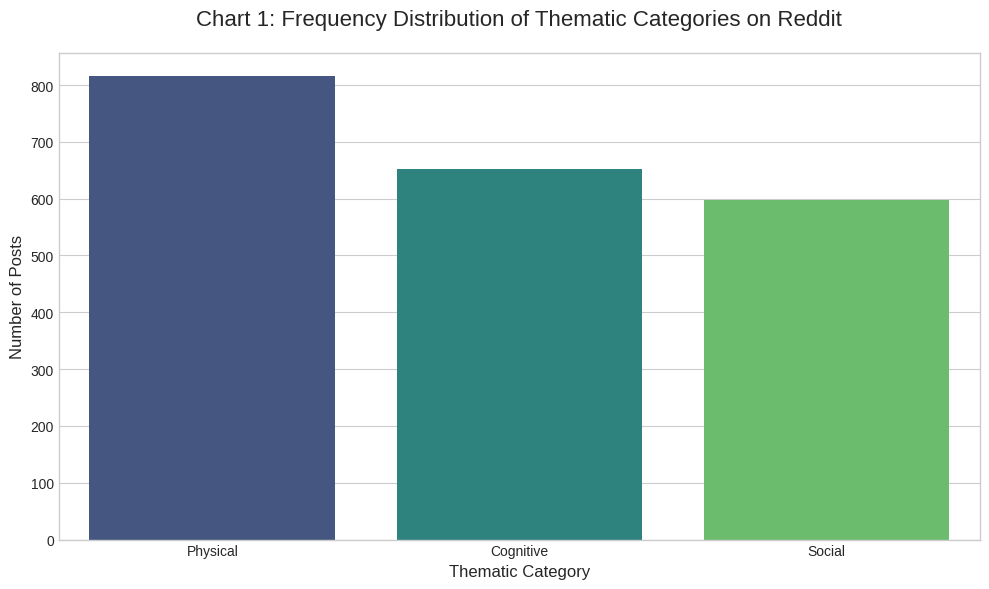



--- Part 3: Analyzing Sentiment Distribution within Each Category ---


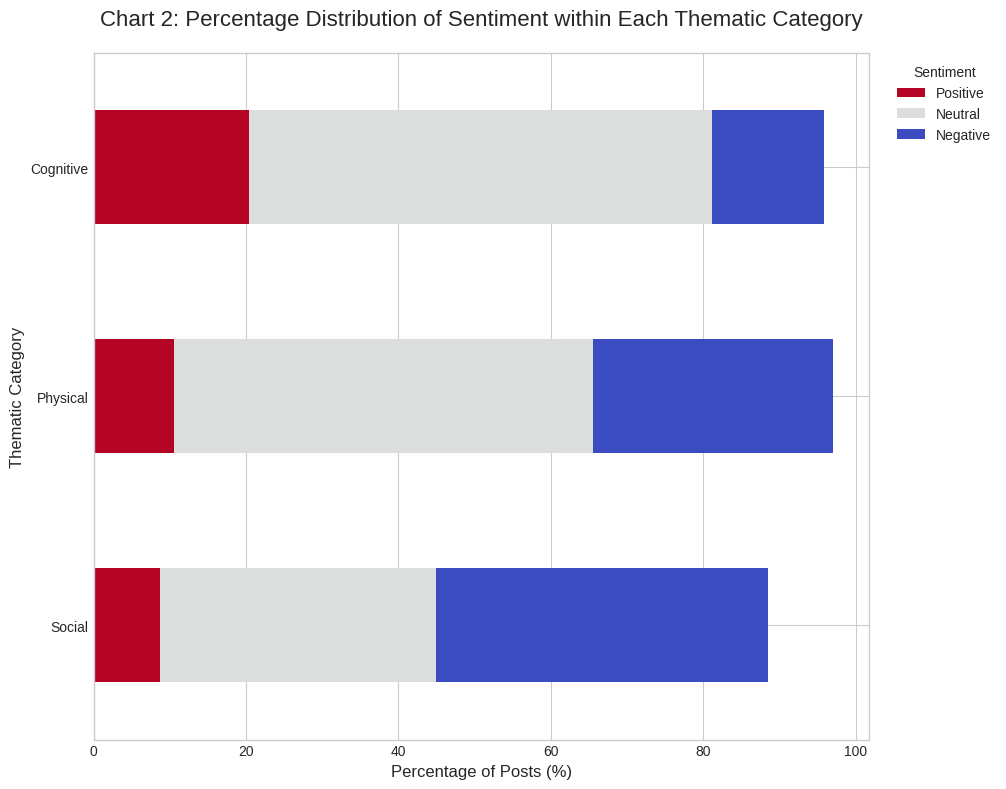



--- Part 4: Final Summary Tables for the Paper ---

--- Table 1: Overall Distribution of Thematic Categories ---


,Total Posts,Percentage of Total
category,,
Physical,816,39.50
Cognitive,653,31.61
Social,597,28.90




--- Table 2: Summary of Results (Post Counts) ---


sentiment,Positive,Negative,Neutral
category,,,
Cognitive,133,96,397
Physical,86,256,449
Social,52,260,216




--- Table 3: Summary of Results (Sentiment Distribution %) ---


sentiment,Error,Negative,Neutral,Positive
category,,,,
Cognitive,4.13,14.70,60.80,20.37
Physical,3.06,31.37,55.02,10.54
Social,11.56,43.55,36.18,8.71


In [7]:
# @title 6: Final Analysis and Visualization (Researcher-in-the-Loop Step)
# In this section, we combine the results from the previous two steps and analyze them based on the paper's theoretical framework.

if 'final_df' in locals() and 'topic_model' in locals():
    print("--- Starting Final Analysis and Visualization Step ---")

    # --------------------------------------------------------------------------
    # Part 1: Mapping Topics to Theoretical Categories (Most Critical Step)
    # --------------------------------------------------------------------------
    print("\n⚠️ Note: Please review the keywords for each topic (printed in cell 4)")
    print("and complete the mapping below based on the theoretical framework (Cognitive, Physical, Social).")

    # This mapping has been updated based on the keyword output you provided.
    # Topics that are unclear or irrelevant (like topic 4) have been excluded from this dictionary.
    topic_mapping = {
        0: 'Social',      # Keywords: me, my, she - Refers to personal experiences and interactions
        1: 'Cognitive',   # Keywords: couche tard, seven, cannabis - Refers to specific companies and product categories
        2: 'Physical',    # Keywords: home depot, lowes - Refers to physical home improvement stores
        3: 'Cognitive',   # Keywords: best buy, amazon - Refers to purchasing decisions from online platforms
        # Topic 4 was excluded due to irrelevance to customer experience (refers to public figures)
        5: 'Physical',    # Keywords: nike, shoes - Refers to tangible, physical products
        6: 'Physical',    # Keywords: jd, alibaba, china - Refers to e-commerce platforms
        7: 'Physical',    # Keywords: mcdonalds, restaurant, food - Refers to restaurant and food product experiences
        8: 'Cognitive',   # Keywords: retailing, business, market, profit - Refers to business and financial aspects
        9: 'Social',      # Keywords: whole foods, workers, profit - Refers to company policies, employees, and social image
    }
    print("\nTopic mapping updated based on your keyword analysis:")
    print(topic_mapping)


    # Apply the mapping to create the 'category' column
    final_df['category'] = final_df['topic_id'].map(topic_mapping)
    # Posts that were not mapped to any category (irrelevant topics or outliers)
    final_df['category'].fillna('Uncategorized', inplace=True)

    # Create the final dataframe with only categorized data
    analysis_df = final_df[final_df['category'] != 'Uncategorized'].copy()
    # Clean up sentiment labels for better display
    analysis_df['sentiment'] = analysis_df['sentiment_label'].str.capitalize()


    # --------------------------------------------------------------------------
    # Part 2: Thematic Category Distribution and Visualization
    # --------------------------------------------------------------------------
    print("\n\n--- Part 2: Analyzing Thematic Category Distribution ---")
    category_dist = analysis_df['category'].value_counts()

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(10, 6))
    sns.barplot(x=category_dist.index, y=category_dist.values, palette="viridis")
    plt.title('Chart 1: Frequency Distribution of Thematic Categories on Reddit', fontsize=16, pad=20)
    plt.xlabel('Thematic Category', fontsize=12)
    plt.ylabel('Number of Posts', fontsize=12)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


    # --------------------------------------------------------------------------
    # Part 3: Sentiment Distribution within Each Category and Visualization
    # --------------------------------------------------------------------------
    print("\n\n--- Part 3: Analyzing Sentiment Distribution within Each Category ---")
    # Create a crosstab to count sentiments per category
    sentiment_dist_per_category = pd.crosstab(analysis_df['category'], analysis_df['sentiment'])
    # Calculate percentages
    sentiment_dist_percent = sentiment_dist_per_category.div(sentiment_dist_per_category.sum(axis=1), axis=0) * 100

    # Plot a horizontal stacked bar chart
    sentiment_dist_percent[['Positive', 'Neutral', 'Negative']].plot(
        kind='barh',
        stacked=True,
        colormap='coolwarm_r', # Red colors for negative, blue for positive
        figsize=(12, 8)
    )
    plt.title('Chart 2: Percentage Distribution of Sentiment within Each Thematic Category', fontsize=16, pad=20)
    plt.xlabel('Percentage of Posts (%)', fontsize=12)
    plt.ylabel('Thematic Category', fontsize=12)
    plt.legend(title='Sentiment', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.gca().invert_yaxis() # The category with the highest frequency will be at the top
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()


    # --------------------------------------------------------------------------
    # Part 4: Generating Final Tables for the Paper
    # --------------------------------------------------------------------------
    print("\n\n--- Part 4: Final Summary Tables for the Paper ---")

    # Table 1: Overall Distribution of Thematic Categories
    category_summary_table = category_dist.to_frame('Total Posts')
    category_summary_table['Percentage of Total'] = (category_summary_table['Total Posts'] / category_summary_table['Total Posts'].sum() * 100).round(2)
    print("\n--- Table 1: Overall Distribution of Thematic Categories ---")
    display(category_summary_table)

    # Table 2: Summary of Results (Post Counts by Sentiment)
    # Ensure all sentiment columns exist
    for col in ['Positive', 'Negative', 'Neutral']:
        if col not in sentiment_dist_per_category.columns:
            sentiment_dist_per_category[col] = 0
    summary_table_counts = sentiment_dist_per_category[['Positive', 'Negative', 'Neutral']]
    print("\n\n--- Table 2: Summary of Results (Post Counts) ---")
    display(summary_table_counts)

    # Table 3: Summary of Results (Sentiment Distribution %)
    print("\n\n--- Table 3: Summary of Results (Sentiment Distribution %) ---")
    display(sentiment_dist_percent.round(2))

else:
    print("❌ Required variables for the final analysis were not found. Please ensure all previous steps have been executed successfully.")
